# DMS alpha- synuclein

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split

from Bio import SeqIO
import joblib
from sklearn.preprocessing import MinMaxScaler

torch.cuda.empty_cache()

## Data pre-processing

In [53]:
data = pd.read_excel('data/cb0c00339_si_002.xlsx', index_col=0)
data

,W,Y,F,L,I,V,M,C,A,G,P,S,T,N,Q,H,R,K,D,E
1,0.645631,0.384739,0.643215,0.628082,0.607942,NaN,0.000000,0.640626,0.604611,0.599873,0.633575,NaN,NaN,0.629992,0.624209,0.637284,0.637986,0.643052,0.639739,0.629064
2,0.188657,0.034327,-0.055355,-0.056184,0.136754,0.430195,0.055314,0.060914,0.223995,0.410560,0.264693,0.157764,NaN,-0.063598,-0.018077,0.015558,0.257129,0.180277,0.000000,0.238997
3,0.139869,0.184946,0.062915,0.040844,0.108747,0.000000,0.029829,0.118255,0.110775,0.235237,0.572019,0.080056,0.427101,0.086428,0.096089,0.078165,-0.074486,0.190046,0.242486,0.409446
4,0.053232,0.000000,0.274371,0.030018,0.021271,0.194697,0.111909,0.219058,0.483499,0.551050,0.595786,0.526108,0.535909,0.496316,0.532204,NaN,0.519989,0.519161,0.370481,0.530801
5,0.035749,0.268188,0.096598,0.514890,0.459631,0.001480,0.000000,0.241395,0.146913,0.295428,0.608295,0.145951,0.290156,0.156247,0.470298,0.546305,-0.049651,-0.002347,0.454796,0.401479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-0.017798,-0.006899,0.000000,0.001461,0.005656,0.010760,0.001087,0.007314,0.052456,0.039369,0.016958,-0.039147,0.041608,0.093290,0.014847,0.014390,0.027483,0.005113,0.186374,0.085998
137,0.024781,0.016178,-0.000680,0.017183,0.074224,0.055461,0.056399,0.020844,0.015159,0.025180,0.060228,-0.004795,0.054438,0.064648,0.043943,0.016748,-0.000306,0.069250,0.004428,0.000000
138,-0.007228,-0.008825,0.020536,0.057790,0.064414,0.007807,0.027238,-0.004019,-0.006004,-0.017850,0.000000,0.000191,0.035842,0.080669,0.061661,0.045439,0.044046,0.053950,0.031880,0.078690
139,0.011899,-0.026113,-0.033153,0.047468,-0.019269,-0.007792,0.030250,0.133334,0.017327,0.031511,0.058277,-0.014332,0.096514,-0.015149,0.054441,0.035881,0.012031,-0.000441,0.015724,0.000000


In [3]:
# wt_seq = []
# for row in data.iterrows():
#     if 0 in row[1].values:
#         wt = row[1][row[1] == 0].index[0]
#         wt_seq.append(wt)

# a_syn_rec = ''.join(wt_seq)
# a_syn_rec

In [54]:
## wild type sequence
a_syn = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'
len(a_syn)

140

In [5]:
# this will organize the matrix into a data frame
muts_effect = {}
for column in data.columns:
    for index, row in data.iterrows():
        mut = a_syn[index-1] + str(index) + column
        muts_effect[mut]= data.loc[index, column]
  

meta_data = pd.DataFrame.from_dict(muts_effect, orient='index').reset_index()
meta_data.rename(columns={'index':'mutation', 0:'effect'}, inplace=True)
meta_data.dropna(inplace=True)
meta_data

,mutation,effect
0,M1W,0.645631
1,D2W,0.188657
2,V3W,0.139869
3,F4W,0.053232
4,M5W,0.035749
...,...,...
2795,Y136E,0.085998
2796,E137E,0.000000
2797,P138E,0.078690
2798,E139E,0.000000


In [6]:
import re

def mutated_seqs(wt_seq, mutation):
    ''' This function will take a wild type sequence and a mutation and return the mutated sequence.'''
    wt_AA, position, mut_AA = re.findall(r'[A-Za-z]+|\d+', mutation)
    coor = int(position)-1
    
    if wt_AA == mut_AA:
        mutated_seq = ''
    elif wt_seq[coor] == wt_AA:
        mutated_seq = wt_seq[:coor] + mut_AA + wt_seq[coor+1:]
    elif wt_seq[coor] != wt_AA:
        mutated_seq = ''
    else:
        print(f'Error: {wt_AA} is not the amino acid at position {position}.')

    return mutated_seq

mutated_seqs(a_syn, 'Y93F')


''

In [7]:
# add mutated sequence to the meta_data
meta_data['mutated_seq'] = meta_data['mutation'].apply(lambda x: mutated_seqs(a_syn, x))
meta_data.query('mutated_seq != ""', inplace=True)
meta_data

,mutation,effect,mutated_seq
0,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,M5W,0.035749,MDVFWKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...,...
2793,Q134E,0.042210,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2794,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2795,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2797,P138E,0.078690,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


In [8]:
## add wild type to the meta_data
new_row = pd.DataFrame.from_dict({'mutation':'WT', 'effect':0, 'mutated_seq':a_syn}, orient='index').T
meta_data = pd.concat([new_row, meta_data]).reset_index(drop=True) 
meta_data

,mutation,effect,mutated_seq
0,WT,0,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...,...
2499,Q134E,0.04221,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2500,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2501,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2502,P138E,0.07869,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


In [11]:
#meta_data.to_csv('data/a-syn_DMS_meta_data.csv', index=False)

In [9]:
# with open('data/a_syn_DMS_sequences.fasta', 'w') as f:
#     for ID, seq in zip(meta_data.mutation, meta_data.mutated_seq):
#         f.write(f'>{ID}\n{seq}\n')

## Machine Learning

In [2]:
## load meta data
meta_data = pd.read_csv('data/a-syn_DMS_meta_data.csv')
meta_data

,mutation,effect,mutated_seq
0,WT,0.000000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...,...
2499,Q134E,0.042210,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2500,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2501,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2502,P138E,0.078690,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


### Using esm2 to extract embeddings

In [3]:
#python scripts/extract.py esm2_t30_150M_UR50D data/a_syn_DMS_sequences.fasta embeddings/ --include mean

### Loading embeddings

In [37]:
def load_mean_embeds(dir_path):
    '''Iterate over the layers embeddings splited and load the embeddings per layer'''
     # list of all files containing the embeddings and created a dictionary
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    embeddings = {}
    for file in os.listdir(dir_path):
        if file.endswith('.pt'):
            file_path = os.path.join(dir_path, file)
            label = file.split('.pt')[0]
            embeddings[label] = np.array(torch.load(file_path)['mean_representations'][30])

    # convert to array type sequences_embeddings to a data frame
    df=pd.DataFrame.from_dict(embeddings, orient='index').reset_index()
    df.rename(columns={'index':'mutation'}, inplace=True)
    return df

In [5]:
#embeds = load_mean_embeds('embeddings/a-syn_DMS_esm2_150M_mean/')
#embeds.to_pickle('embeddings/a-syn_DMS_esm2_150M_mean.pkl')

In [3]:
embeds = pd.read_pickle('embeddings/a-syn_DMS_esm2_150M_mean.pkl')
data = meta_data.merge(embeds, on='mutation', how='inner')
data

,mutation,effect,mutated_seq,0,1,2,3,4,5,6,...,630,631,632,633,634,635,636,637,638,639
0,WT,0.000000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.087509,-0.141573,-0.045375,0.147647,0.033079,0.006423,0.054152,...,-0.099348,-0.043451,-0.344581,-0.167214,0.044787,0.155121,0.010069,-0.010588,0.039759,-0.029401
1,M1W,0.645631,WDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.090933,-0.153992,-0.042397,0.145299,0.034432,0.005734,0.048089,...,-0.104135,-0.049668,-0.337335,-0.159240,0.044105,0.158015,0.019436,-0.006092,0.025239,-0.031818
2,D2W,0.188657,MWVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.082556,-0.128089,-0.047340,0.150281,0.032487,0.003248,0.046689,...,-0.100386,-0.038188,-0.347550,-0.166431,0.036915,0.153154,0.010328,-0.006035,0.050581,-0.021108
3,V3W,0.139869,MDWFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.084100,-0.128871,-0.052628,0.156018,0.042377,0.004063,0.058364,...,-0.098583,-0.042095,-0.349069,-0.176929,0.053934,0.148816,0.005886,-0.018491,0.050297,-0.019814
4,F4W,0.053232,MDVWMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.088567,-0.150872,-0.034862,0.137815,0.031768,0.002539,0.052404,...,-0.099022,-0.045338,-0.341825,-0.160897,0.045057,0.152263,0.013747,-0.009967,0.030347,-0.033513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,Q134E,0.042210,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.084843,-0.134074,-0.043362,0.153934,0.035164,0.009269,0.053370,...,-0.097078,-0.037660,-0.346975,-0.162851,0.046984,0.152138,0.007908,-0.006641,0.041838,-0.031886
2500,D135E,-0.031937,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.090307,-0.141505,-0.044951,0.144684,0.031088,0.003180,0.051620,...,-0.101185,-0.043925,-0.340361,-0.162881,0.046856,0.157510,0.010811,-0.007872,0.034212,-0.030766
2501,Y136E,0.085998,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.070960,-0.133653,-0.046690,0.150734,0.030844,0.010397,0.052741,...,-0.092509,-0.040589,-0.364932,-0.164128,0.038324,0.152684,0.002551,-0.006389,0.040506,-0.027303
2502,P138E,0.078690,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.078912,-0.135841,-0.044238,0.145504,0.038064,0.011989,0.050778,...,-0.097606,-0.038808,-0.339996,-0.171923,0.049432,0.154854,0.008508,-0.001956,0.046822,-0.026920


In [52]:
def features_scaler(features):
    '''Scale the features by min-max scaler, to ensure that the features selected by Lasso are not biased by the scale of the features'''
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_features = scaler.fit_transform(features)
    return pd.DataFrame(scaled_features)

In [4]:
features = data.iloc[:, meta_data.shape[1]:]
#features = features_scaler(features)
features

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,0.087509,-0.141573,-0.045375,0.147647,0.033079,0.006423,0.054152,0.041003,-0.120777,0.178101,...,-0.099348,-0.043451,-0.344581,-0.167214,0.044787,0.155121,0.010069,-0.010588,0.039759,-0.029401
1,0.090933,-0.153992,-0.042397,0.145299,0.034432,0.005734,0.048089,0.047545,-0.118004,0.178723,...,-0.104135,-0.049668,-0.337335,-0.159240,0.044105,0.158015,0.019436,-0.006092,0.025239,-0.031818
2,0.082556,-0.128089,-0.047340,0.150281,0.032487,0.003248,0.046689,0.038184,-0.122410,0.171774,...,-0.100386,-0.038188,-0.347550,-0.166431,0.036915,0.153154,0.010328,-0.006035,0.050581,-0.021108
3,0.084100,-0.128871,-0.052628,0.156018,0.042377,0.004063,0.058364,0.037778,-0.129637,0.178327,...,-0.098583,-0.042095,-0.349069,-0.176929,0.053934,0.148816,0.005886,-0.018491,0.050297,-0.019814
4,0.088567,-0.150872,-0.034862,0.137815,0.031768,0.002539,0.052404,0.038503,-0.120901,0.176597,...,-0.099022,-0.045338,-0.341825,-0.160897,0.045057,0.152263,0.013747,-0.009967,0.030347,-0.033513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0.084843,-0.134074,-0.043362,0.153934,0.035164,0.009269,0.053370,0.042352,-0.118468,0.175611,...,-0.097078,-0.037660,-0.346975,-0.162851,0.046984,0.152138,0.007908,-0.006641,0.041838,-0.031886
2500,0.090307,-0.141505,-0.044951,0.144684,0.031088,0.003180,0.051620,0.042855,-0.122125,0.181962,...,-0.101185,-0.043925,-0.340361,-0.162881,0.046856,0.157510,0.010811,-0.007872,0.034212,-0.030766
2501,0.070960,-0.133653,-0.046690,0.150734,0.030844,0.010397,0.052741,0.044443,-0.114730,0.183742,...,-0.092509,-0.040589,-0.364932,-0.164128,0.038324,0.152684,0.002551,-0.006389,0.040506,-0.027303
2502,0.078912,-0.135841,-0.044238,0.145504,0.038064,0.011989,0.050778,0.040695,-0.120801,0.176799,...,-0.097606,-0.038808,-0.339996,-0.171923,0.049432,0.154854,0.008508,-0.001956,0.046822,-0.026920


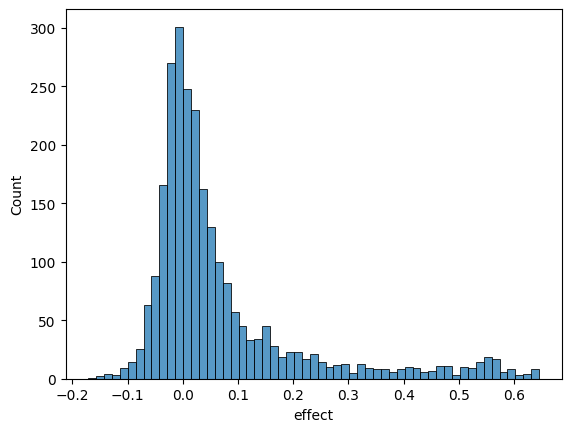

In [5]:
target = data['effect']
sns.histplot(target)
plt.show()  

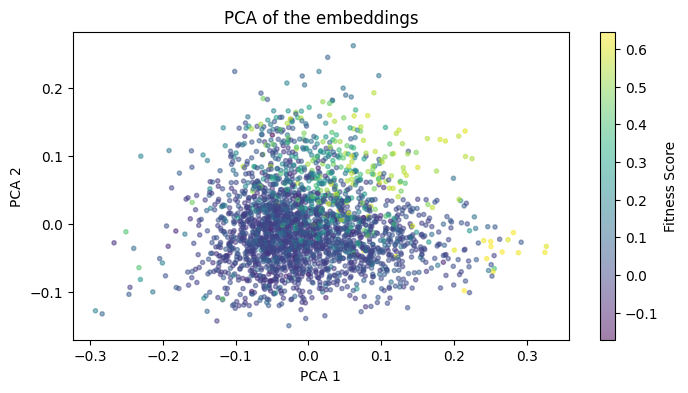

In [6]:
num_pca=2
pca = PCA(num_pca)
X_pca = pca.fit_transform(features)

fig, ax = plt.subplots(figsize=(8, 4))
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=target, marker='.', alpha=0.5)
plt.title('PCA of the embeddings')
plt.colorbar(sc, label='Fitness Score')
plt.ylabel('PCA 2')
plt.xlabel('PCA 1')
plt.savefig('results/pca_embeddings.png')
plt.show()


In [7]:
def run_regression_v2(features, target):
    '''this version computes y_pred for train and test sets'''
    # Initialize lists for storing results
    folds = []
    r2s_train,  maes_train, rmses_train = [], [], []
    r2s_test, maes_test, rmses_test = [], [], []

    # Define the KFold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Loop over the KFold splits
    for kfold, (train_index, test_index) in enumerate(kf.split(features)):
        # Split the data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Define and train the regression model
        #model = Lasso(alpha=0.0004, random_state=42, max_iter=10000, tol=0.001) # for scaled features
        model = Lasso(alpha=0.00001, random_state=42, max_iter=10000, tol=0.001)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = pd.DataFrame(model.predict(X_train))
        y_pred_test = pd.DataFrame(model.predict(X_test))

        # Evaluate the model
        r2_train = metrics.r2_score(y_train, y_pred_train)
        mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
        mse_train = metrics.mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)

        r2_test = metrics.r2_score(y_test, y_pred_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        

        # Append results
        r2s_train.append(r2_train)
        maes_train.append(mae_train)
        rmses_train.append(rmse_train)

        r2s_test.append(r2_test)
        maes_test.append(mae_test)
        rmses_test.append(rmse_test)

        folds.append(kfold + 1)

        #print(f"Fold {kfold + 1}, R2 (train): {r2_train:.2f}, R2 (test): {r2_test:.2f},")

    # retrain the model on the entire dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = {
        'actual_train': [], 'predicted_train': [],
        'actual_test': [], 'predicted_test': [],
        }
    y_pred_train = pd.DataFrame(model.predict(X_train))
    y_pred_test = pd.DataFrame(model.predict(X_test))

    predictions['actual_train'].extend(y_train.values)
    predictions['actual_test'].extend(y_test.values)

    predictions['predicted_train'].extend(y_pred_train.values)
    predictions['predicted_test'].extend(y_pred_test.values)


    # Return the collected results
    return folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, predictions, model


def save_results_v2(folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test):
    # Create dictionary for results
    res_dict = {
        "Model": ['Lasso'] * 10,
        "Fold": folds,
        "R2_score_train": r2s_train,
        "MAE_score_train": maes_train,
        "RMSE_score_train": rmses_train,
        "R2_score_test": r2s_test,
        "MAE_score_test": maes_test,
        "RMSE_score_test": rmses_test,
    }

    # Convert results to DataFrame
    results = pd.DataFrame(res_dict).reset_index(drop=True)
    return results

In [8]:
folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, predictions, model = run_regression_v2(features, target)
save_results_v2(folds, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test)

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test
0,Lasso,1,0.748840,0.054294,0.073910,0.694776,0.051617,0.071706
1,Lasso,2,0.746887,0.053844,0.073367,0.690139,0.058314,0.081237
2,Lasso,3,0.735582,0.053913,0.073889,0.775003,0.056116,0.077630
3,Lasso,4,0.743961,0.054175,0.074237,0.706059,0.057210,0.074223
4,Lasso,5,0.748422,0.053597,0.073243,0.690786,0.059319,0.080152
5,Lasso,6,0.741801,0.054340,0.074690,0.751985,0.051550,0.067203
6,Lasso,7,0.749423,0.053164,0.073166,0.675788,0.061909,0.081371
7,Lasso,8,0.733864,0.054716,0.074460,0.793310,0.052212,0.071957
8,Lasso,9,0.748855,0.054448,0.074103,0.675225,0.050496,0.071716
9,Lasso,10,0.747929,0.052764,0.071898,0.676761,0.065814,0.094529


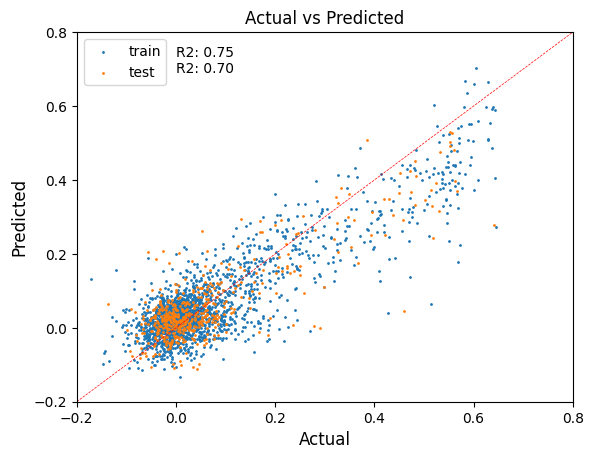

In [9]:
# plot train vs test
plt.scatter(predictions['actual_train'], predictions['predicted_train'], s=1, label='train',)
plt.scatter(predictions['actual_test'], predictions['predicted_test'], s=1, label='test',)
r2_train = metrics.r2_score(predictions['actual_train'], predictions['predicted_train'])
r2_test = metrics.r2_score(predictions['actual_test'], predictions['predicted_test'])
plt.xlabel('Actual', size=12)
plt.ylabel('Predicted', size=12)
plt.title('Actual vs Predicted')
plt.ylim(-0.2, 0.8)
plt.xlim(-0.2, 0.8)
plt.plot([-0.2, 0.8], [-0.2, 0.8], color='red', linestyle='--', linewidth=0.5)
plt.text(0.0, 0.69, f'R2: {r2_train:.2f}\nR2: {r2_test:.2f}', fontsize=10)
plt.legend()
plt.savefig('results/actual_vs_predicted.png')
plt.show()

In [93]:
# save the model
#joblib.dump(model, 'model/model_lasso_fitness_a-syn_v01.pkl')

In [94]:
stop

NameError: name 'stop' is not defined

# Using logits to mutate each position with the top 5 most probable amino acid

In [76]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from esm import Alphabet, FastaBatchedDataset, pretrained

In [77]:
model, alphabet = pretrained.esm2_t30_150M_UR50D()

batch_converter = alphabet.get_batch_converter()
model.eval() 

ESM2(
  (embed_tokens): Embedding(33, 640, padding_idx=1)
  (layers): ModuleList(
    (0-29): 30 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=640, out_features=640, bias=True)
        (v_proj): Linear(in_features=640, out_features=640, bias=True)
        (q_proj): Linear(in_features=640, out_features=640, bias=True)
        (out_proj): Linear(in_features=640, out_features=640, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=640, out_features=2560, bias=True)
      (fc2): Linear(in_features=2560, out_features=640, bias=True)
      (final_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=600, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((640,), eps=1e-05, elementw

In [78]:
a_syn = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'

data = [
    ('a_syn', a_syn),
    ]

batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[30], return_contacts=True)

results.keys()

dict_keys(['logits', 'representations', 'attentions', 'contacts'])

In [79]:
esm_alphabet = ['<cls>','<pad>','<eos>','<unk>','L','A','G','V','S','E','R','T','I','D','P','K','Q','N','F','Y','M','H','W','C','X','B','U','Z','O','.','-','<null_1>','<mask>']
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

logits = results['logits']

logits_df = pd.DataFrame(logits[0], columns=esm_alphabet)[amino_acids]
logits_df = logits_df.iloc[1:141,:]  
logits_df 

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
1,0.215675,-2.587056,-0.612135,-0.327744,-0.426691,-0.064636,-1.325242,-0.830447,0.758505,-0.135911,6.163942,-1.032182,-1.011080,-1.000492,-0.287907,-0.149253,-0.089327,-0.040280,-1.401067,-1.176859
2,0.824968,-2.925770,5.288593,1.719624,-1.658447,1.017239,-2.548161,-1.853758,-0.371793,-1.594133,-2.146243,0.372045,-1.269078,-0.474698,-2.092502,1.335821,-0.349646,-0.991646,-3.630011,-2.861696
3,0.527132,-3.041126,0.796727,0.367994,-0.971004,0.747911,-2.512206,-1.854637,1.091207,-1.499162,-1.811417,1.047769,-3.534380,-0.237386,-0.976305,1.122975,0.781707,1.952256,-1.175577,-2.270577
4,1.246157,-2.048675,-1.751876,-1.866792,5.129389,-1.622558,-3.675240,2.280826,-1.208677,2.297453,0.688722,-2.338026,-2.062307,-2.676848,-2.697805,-1.960327,-0.517105,2.563959,-1.484074,-1.545513
5,0.816630,-2.621696,-1.648895,0.208973,-1.402493,0.208997,-2.291964,-0.763953,3.426297,-0.411971,2.353295,0.101380,-4.600524,0.841615,0.113805,1.426330,1.330479,0.283062,-3.700230,-2.652324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,0.203436,-3.776004,0.980548,1.956759,-0.602330,0.718782,-1.536863,-0.705135,-0.233766,-0.068017,-0.656196,-0.132361,0.341512,0.385718,-1.072764,-0.070435,-0.208111,-0.007278,-2.429032,3.105380
137,0.005361,-3.734946,0.158037,4.031384,-1.192439,-0.419915,-1.014528,-0.456619,0.286437,-0.444959,-1.110293,0.048077,0.868845,0.255340,-0.228614,-0.239873,-0.002431,0.175585,-2.906250,-0.305921
138,-0.005753,-3.688968,1.114279,1.557436,-1.323107,0.561184,-1.398783,-0.772439,0.288449,-0.488939,-0.928486,0.186373,3.641316,-0.007040,-0.825587,-0.253346,-0.302843,-0.257883,-2.656447,-0.242854
139,0.129065,-3.497645,-0.555880,3.869255,-0.923021,-0.379087,-1.052833,-0.665005,1.012574,-0.269690,-1.106360,-0.295324,-0.102040,0.210979,0.147853,-0.308350,-0.273274,-0.085276,-2.403629,-0.795714


In [80]:
top5_logits = list(logits_df.apply(lambda row: row.nlargest(5).index.tolist(), axis=1))
top5_logits[0]

['M', 'K', 'A', 'V', 'G']

In [82]:
for i, (top5, seq) in enumerate(zip(top5_logits, a_syn)):
    print(f'{i+1} {seq} {top5}')
    break

1 M ['M', 'K', 'A', 'V', 'G']


In [30]:
# estimated number of sequences
(140**2 )* 25

490000

In [ ]:
seqs = set()
seqs.add(a_syn)

for idx1 in range(len(a_syn)):
    for sub1 in top5_logits[idx1]:
        for idx2 in range(len(a_syn)):
            for sub2 in top5_logits[idx2]:

                if idx1 != idx2:
                    seq1 = a_syn[:idx1] + sub1 + a_syn[idx1+1:]
                    seq2 = seq1[:idx2] + sub2 + seq1[idx2+1:]
                    seqs.add(seq2)

df = pd.DataFrame(seqs)
df = df.reset_index()
df.rename(columns={'index':'ID', 0:'Sequence'}, inplace=True)
df['ID'] = '2mut_'+ df['ID'].astype(str)
df

,ID,Sequence
0,2mut_0,MDVFMKTLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,2mut_1,MDVFMKGLSKAKEGVVTAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,2mut_2,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,2mut_3,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,2mut_4,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...
156236,2mut_156236,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
156237,2mut_156237,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGATKEGVLYVGSKTKE...
156238,2mut_156238,MDVFMKGLNKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
156239,2mut_156239,GDVFMKGLSKAKEGVVAVAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


In [ ]:
## create and saving a fasta file

# dict_seq = dict(zip(df['ID'], df['Sequence']))
# with open('data/a_syn_top5_logs_variants_2mut.fasta', 'a') as f:
#         for k,v in dict_seq.items():
#                 f.write(f'>{k}\n{v}\n') 

## Creating mutated sequences with all 20 AAs

In [31]:
(140**2) *20*20

7840000

In [10]:
## # doble mutant
a_syn = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'
aa_list = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

seqs = set()
seqs.add(a_syn)

for idx1 in range(len(a_syn)):
    for sub1 in aa_list:
        for idx2 in range(len(a_syn)):
            for sub2 in aa_list:

                if idx1 != idx2:

                    seq1 = a_syn[:idx1] + sub1 + a_syn[idx1+1:]
                    seq2 = seq1[:idx2] + sub2 + seq1[idx2+1:]
                    seqs.add(seq2)

df = pd.DataFrame(seqs)
df.sort_values(by=0, inplace=True)

In [11]:
df = df.sample(150000).copy()
df = df.reset_index()
df.rename(columns={'index':'ID', 0:'Sequence'}, inplace=True)
df

,ID,Sequence
0,1393702,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,1590381,MDVFMKGLSKAKEGVVAAAEKTKQGVREAAGKTKETVLYVGSKTKE...
2,454723,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKSKEGVLYVGSKTKE...
3,1044419,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,3351177,MDVFMKGLSKAKEGVVSAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...
149995,1472989,MDFFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
149996,2816632,MDVFMKGLSKAKEGVVAAAEKTKSGVAEAAGKTKEGVLYVGSKTGE...
149997,186000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
149998,1689260,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


In [12]:
## create and saving a fasta file

# dict_seq = dict(zip(df['ID'], df['Sequence']))
# with open('data/a_syn_all_AA_150K_variants_2mut.fasta', 'a') as f:
#         for k,v in dict_seq.items():
#                 f.write(f'>{k}\n{v}\n') 

# Load embedding from the in silic library

In [2]:
# load model
model = joblib.load('model/model_lasso_fitness_a-syn_v01.pkl')

In [3]:
meta_data_dict = {}
for rec in SeqIO.parse('data/a_syn_top5_logs_variants_2mut.fasta', 'fasta'):
    meta_data_dict[rec.id] = str(rec.seq)

In [4]:
muts = pd.DataFrame.from_dict(meta_data_dict, orient='index').reset_index()
muts.rename(columns={0:'Sequence', 'index':'ID'}, inplace=True)
muts

,ID,Sequence
0,2mut_0,MDVFMKGLSKAKEGVVAAGEKTKQGVAEAGGKTKEGVLYVGSKTKE...
1,2mut_1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2,2mut_2,MDVFMKGLSKAKEGVAAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
3,2mut_3,MDVFMKGLSKAKEGVVAAAEKTKQGLAEAAGKTKEGVLYVGSKTKE...
4,2mut_4,MDVFMKGLSKAKEGVVAAASKTKQGVAEAAGKTKEGVLYVGSKAKE...
...,...,...
156236,2mut_156236,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGTTKEGVLYVGSVTKE...
156237,2mut_156237,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
156238,2mut_156238,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
156239,2mut_156239,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGYTKEGVLYVGSKTKE...


In [5]:
#embeds = load_mean_embeds('embeddings/a_syn_top5_logs_2mut_esm2_150M_mean')
embeds = pd.read_pickle('embeddings/a_syn_top5_logs_2mut_esm2_150M_mean.pkl')
embeds

,mutation,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
0,2mut_46297,0.086145,-0.147129,-0.041674,0.151402,0.027335,0.012626,0.054204,0.042483,-0.110736,...,-0.084651,-0.045752,-0.348061,-0.162930,0.042895,0.152765,0.014989,-0.004586,0.028727,-0.031077
1,2mut_21350,0.095558,-0.157477,-0.030247,0.140130,0.042526,0.005886,0.046592,0.045453,-0.112439,...,-0.097021,-0.046254,-0.318755,-0.159327,0.052940,0.163124,0.008861,-0.006630,0.033815,-0.035003
2,2mut_139247,0.101183,-0.152174,-0.039247,0.135480,0.038019,-0.004711,0.061938,0.040816,-0.123452,...,-0.102714,-0.046983,-0.341352,-0.162553,0.040589,0.154942,0.005039,-0.020670,0.031029,-0.034774
3,2mut_96034,0.082517,-0.137249,-0.026409,0.155325,0.022832,0.006998,0.045424,0.025790,-0.119066,...,-0.093557,-0.048680,-0.341000,-0.166782,0.040077,0.162303,0.019744,-0.010167,0.033724,-0.023335
4,2mut_135567,0.072307,-0.121123,-0.047636,0.156966,0.032408,0.003039,0.046723,0.034710,-0.118244,...,-0.088172,-0.035987,-0.346075,-0.171209,0.029020,0.143610,0.018774,-0.003873,0.047549,-0.023765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156236,2mut_99718,0.087758,-0.154374,-0.038839,0.132784,0.029104,0.011705,0.051428,0.049542,-0.118165,...,-0.103996,-0.044858,-0.335938,-0.177025,0.038855,0.156801,0.001189,-0.012567,0.039451,-0.026146
156237,2mut_154550,0.079145,-0.131543,-0.050438,0.157451,0.034359,0.012860,0.061556,0.041666,-0.121826,...,-0.096100,-0.038744,-0.333470,-0.158541,0.043525,0.160010,0.008681,-0.004786,0.040858,-0.026825
156238,2mut_40367,0.075082,-0.141448,-0.042765,0.147300,0.023670,0.009795,0.058911,0.039100,-0.117816,...,-0.096303,-0.036286,-0.362971,-0.155185,0.026466,0.167545,0.000780,-0.002870,0.032029,-0.033208
156239,2mut_95038,0.094696,-0.154994,-0.051131,0.143128,0.038851,0.016479,0.052387,0.045590,-0.110477,...,-0.095521,-0.048682,-0.350811,-0.178278,0.046955,0.151874,0.011143,-0.008077,0.043251,-0.031534


In [6]:
X = embeds.iloc[:, 1:]
pred = model.predict(X)
muts['predictions'] = pred
muts

,ID,Sequence,predictions
0,2mut_0,MDVFMKGLSKAKEGVVAAGEKTKQGVAEAGGKTKEGVLYVGSKTKE...,0.144570
1,2mut_1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.126597
2,2mut_2,MDVFMKGLSKAKEGVAAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.076776
3,2mut_3,MDVFMKGLSKAKEGVVAAAEKTKQGLAEAAGKTKEGVLYVGSKTKE...,0.178854
4,2mut_4,MDVFMKGLSKAKEGVVAAASKTKQGVAEAAGKTKEGVLYVGSKAKE...,0.022611
...,...,...,...
156236,2mut_156236,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGTTKEGVLYVGSVTKE...,0.078359
156237,2mut_156237,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,-0.046915
156238,2mut_156238,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,-0.011682
156239,2mut_156239,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGYTKEGVLYVGSKTKE...,0.134552


In [7]:
# def to find the differences between the residues

def diff_func(idxx):
    a_syn = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'
    idx = idxx
    diff = []
    for i in range(0, len(a_syn)):
        aa = idx[i]
        pg_aa = a_syn[i]
        
        if pg_aa == aa:
            diff.append("-")
        else:
            diff.append(aa)
    diff_seq = "".join(diff)
    return diff_seq


diff_func(muts.iloc[0, 1])

'------------------G----------G--------------------------------------------------------------------------------------------------------------'

In [8]:
# prepare the matrix to plot the heatmap
muts["difference_in_seq"] = [diff_func(x) for x in muts["Sequence"]]
diff = muts["difference_in_seq"].str.split("", n= -1, expand = True)
muts = muts.merge(diff, left_index=True, right_index=True)
muts

,ID,Sequence,predictions,difference_in_seq,0,1,2,3,4,5,...,132,133,134,135,136,137,138,139,140,141
0,2mut_0,MDVFMKGLSKAKEGVVAAGEKTKQGVAEAGGKTKEGVLYVGSKTKE...,0.144570,------------------G----------G----------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
1,2mut_1,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.126597,----------------------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
2,2mut_2,MDVFMKGLSKAKEGVAAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.076776,---------------A------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
3,2mut_3,MDVFMKGLSKAKEGVVAAAEKTKQGLAEAAGKTKEGVLYVGSKTKE...,0.178854,-------------------------L--------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
4,2mut_4,MDVFMKGLSKAKEGVVAAASKTKQGVAEAAGKTKEGVLYVGSKAKE...,0.022611,-------------------S-----------------------A--...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156236,2mut_156236,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGTTKEGVLYVGSVTKE...,0.078359,-------------------------------T----------V---...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
156237,2mut_156237,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,-0.046915,----------------------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
156238,2mut_156238,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,-0.011682,----------------------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
156239,2mut_156239,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGYTKEGVLYVGSKTKE...,0.134552,-------------------------------Y--------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,


In [18]:
#muts.iloc[:, 0:4].to_excel('results/a_syn_top5_logs_variants_2mut_predictions.xlsx')

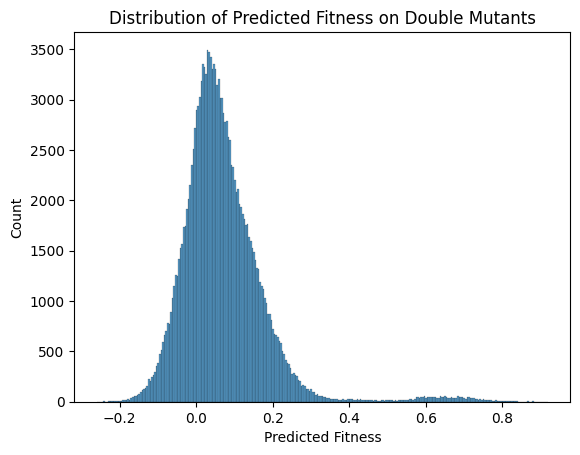

In [10]:
plt.title('Distribution of Predicted Fitness on Double Mutants')
sns.histplot(muts['predictions'])
plt.xlabel('Predicted Fitness')
plt.savefig('results/predicted_fitness_distribution.png')
plt.show() 

In [11]:
muts['predictions'].mean()

0.07039243

In [12]:
# matrix = pd.DataFrame(0, index=range(1, 141), columns=range(1, 141))
# for row, col in muts.iterrows():
#     pos = []
#     for i, v in enumerate(col.loc[1:140], start=1):
#         if v != '-':
#             pos.append(i)
#     if len(pos) == 2:
#         matrix.loc[pos[1], pos[0]] += col['predictions']
# matrix

In [13]:
# plt.figure(figsize=(12, 6))
# sns.heatmap(matrix, cmap='coolwarm', center=0, square=True)
# plt.xticks(rotation=0)
# plt.show()

(47724, 146)


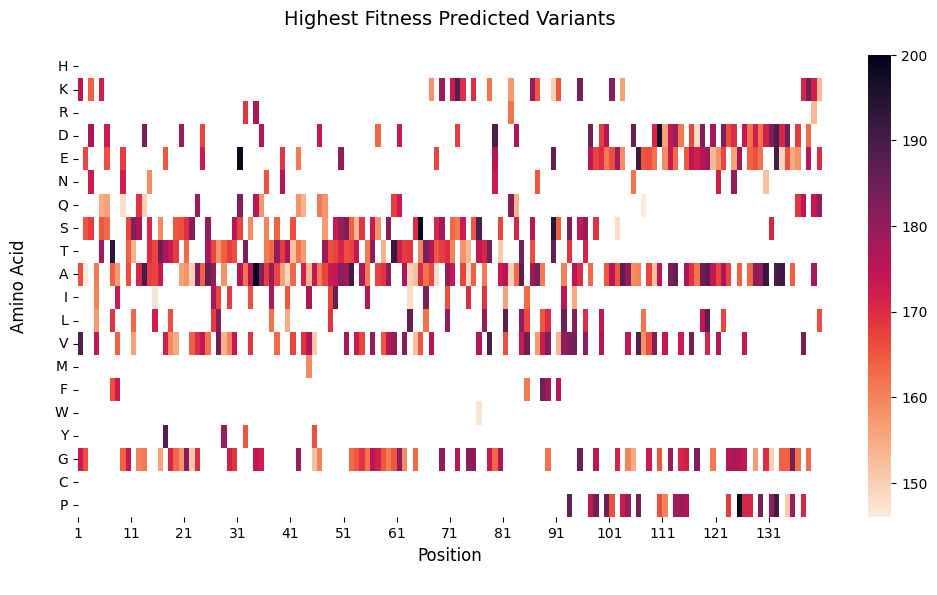

In [14]:
most_act = muts.query('predictions > 0.1')
#most_act = muts[muts['predictions'].between(0.1, 0.45)]

print(most_act.shape)

# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E',     'N', 'Q', 'S', 'T',    'A', 'I', 'L', 'V', 'M',    'F', 'W', 'Y',    'G', 'C','P']

mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 141))

# fill the matix with the count of each amino acid in each position
for i in range(1, 141):
    pos_count = most_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

# plot the heatmap
plt.figure(figsize=(12, 6))
plt.title("Highest Fitness Predicted Variants\n", size=14)
mtx.replace(0, np.nan, inplace=True)
sns.heatmap(mtx, cmap="rocket_r")
plt.xlabel('Position\n', size=12)
plt.ylabel('Amino Acid\n', size=12)
plt.yticks(rotation=0)
plt.xticks(np.arange(0, 140, 10), np.arange(1, 140, 10), rotation=0)
plt.savefig('results/changes_heatmap_predictions_high_fitness.png', dpi=600)
plt.show()

(29214, 146)


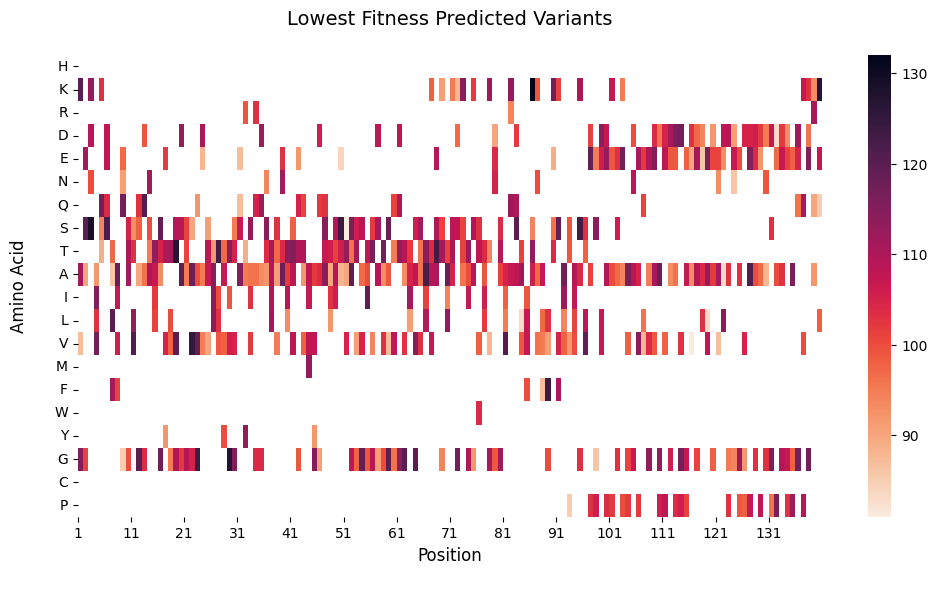

In [15]:
less_act = muts.query('predictions < -0.01')
print(less_act.shape)


# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 141))

# fill the matix with the count of each amino acid in each position
for i in range(1, 141):
    pos_count = less_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

# plot the heatmap
plt.figure(figsize=(12, 6))
plt.title("Lowest Fitness Predicted Variants\n", size=14)
mtx.replace(0, np.nan, inplace=True)
sns.heatmap(mtx, cmap="rocket_r")
plt.xlabel('Position\n', size=12)
plt.ylabel('Amino Acid\n', size=12)
plt.yticks(rotation=0)
plt.xticks(np.arange(0, 140, 10), np.arange(1, 140, 10), rotation=0)
plt.savefig('results/changes_heatmap_predictions_lowest_fitness.png', dpi=600)
plt.show()

In [16]:
stop

NameError: name 'stop' is not defined

## Prediction on the all AA sequences

In [ ]:
meta_data_dict = {}
for rec in SeqIO.parse('data/a_syn_all_AA_150K_variants_2mut.fasta', 'fasta'):
    meta_data_dict[rec.id] = str(rec.seq)

In [ ]:
muts = pd.DataFrame.from_dict(meta_data_dict, orient='index').reset_index()
muts.rename(columns={0:'Sequence', 'index':'ID'}, inplace=True)
muts

,ID,Sequence
0,1393702,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
1,1590381,MDVFMKGLSKAKEGVVAAAEKTKQGVREAAGKTKETVLYVGSKTKE...
2,454723,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKSKEGVLYVGSKTKE...
3,1044419,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
4,3351177,MDVFMKGLSKAKEGVVSAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
...,...,...
149995,1472989,MDFFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
149996,2816632,MDVFMKGLSKAKEGVVAAAEKTKSGVAEAAGKTKEGVLYVGSKTGE...
149997,186000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
149998,1689260,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...


In [ ]:
#embeds = load_mean_embeds('embeddings/a_syn_all_AA_150k_2mut_esm2_150M_mean')
#embeds.to_pickle('embeddings/a_syn_all_AA_150k_2mut_esm2_150M_mean.pkl')
embeds = pd.read_pickle('embeddings/a_syn_all_AA_150k_2mut_esm2_150M_mean.pkl')
embeds

,mutation,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
0,2978513,0.085807,-0.155307,-0.033705,0.135443,0.031889,0.008407,0.048558,0.032718,-0.117889,...,-0.090221,-0.049259,-0.343474,-0.151103,0.040255,0.154799,0.014401,-0.019550,0.028631,-0.039998
1,2863461,0.085259,-0.149301,-0.048813,0.146003,0.024827,0.013483,0.055824,0.039763,-0.118175,...,-0.086036,-0.041145,-0.340124,-0.173919,0.033786,0.155304,0.010255,0.001312,0.041609,-0.030021
2,3255855,0.082410,-0.131586,-0.050220,0.148770,0.038295,0.010880,0.050140,0.047692,-0.108792,...,-0.090390,-0.051862,-0.334948,-0.173967,0.059985,0.144930,0.010279,-0.010647,0.042434,-0.023223
3,2886319,0.087306,-0.146802,-0.035480,0.150159,0.018513,-0.006006,0.052588,0.043188,-0.120483,...,-0.092002,-0.046104,-0.357903,-0.159034,0.035356,0.151227,0.013146,-0.009596,0.029997,-0.049763
4,460966,0.078285,-0.151746,-0.047000,0.139134,0.031029,0.002614,0.053129,0.040867,-0.125860,...,-0.097028,-0.058127,-0.368852,-0.182135,0.039748,0.149943,-0.001226,-0.030112,0.039985,-0.025476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,1539148,0.095302,-0.144870,-0.038776,0.133979,0.022122,0.007984,0.047481,0.030006,-0.108210,...,-0.099419,-0.028946,-0.341017,-0.138550,0.030900,0.160114,0.022070,0.011401,0.027703,-0.035012
149996,3331296,0.074173,-0.124113,-0.038002,0.159803,0.018670,0.016888,0.067335,0.047961,-0.106226,...,-0.092557,-0.031583,-0.342920,-0.134392,0.028154,0.163288,0.023484,-0.003093,0.036577,-0.020934
149997,49382,0.073348,-0.145086,-0.037970,0.140335,0.031054,0.005930,0.046115,0.023484,-0.121313,...,-0.080848,-0.030370,-0.346833,-0.151896,0.029695,0.153905,0.014374,-0.007513,0.042706,-0.028709
149998,348930,0.088461,-0.161896,-0.043226,0.139485,0.023601,0.000324,0.043076,0.040549,-0.122878,...,-0.095778,-0.051147,-0.354904,-0.170047,0.034663,0.154337,0.012037,-0.009159,0.041901,-0.034996


In [ ]:
X = embeds.iloc[:, 1:]
pred = model.predict(X)
muts['predictions'] = pred
muts

,ID,Sequence,predictions
0,1393702,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.278057
1,1590381,MDVFMKGLSKAKEGVVAAAEKTKQGVREAAGKTKETVLYVGSKTKE...,0.174310
2,454723,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKSKEGVLYVGSKTKE...,0.081039
3,1044419,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.043737
4,3351177,MDVFMKGLSKAKEGVVSAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.204030
...,...,...,...
149995,1472989,MDFFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.595748
149996,2816632,MDVFMKGLSKAKEGVVAAAEKTKSGVAEAAGKTKEGVLYVGSKTGE...,0.045290
149997,186000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,-0.004858
149998,1689260,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.041916


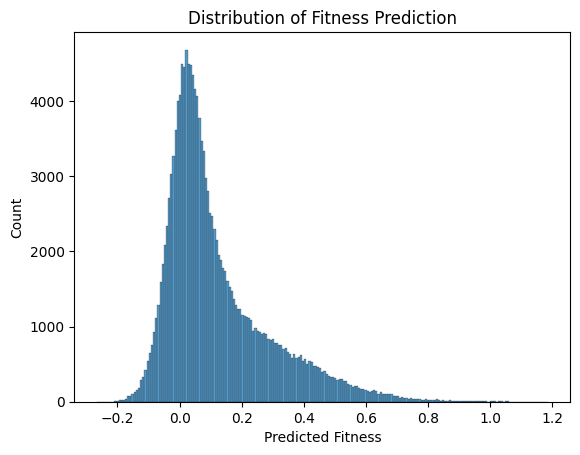

In [ ]:
plt.title('Distribution of Fitness Prediction')
sns.histplot(muts['predictions'])
plt.xlabel('Predicted Fitness')
#plt.savefig('results/predicted_fitness_distribution.png')
plt.show() 

In [ ]:
muts['predictions'].mean()

0.1207247

In [ ]:
# prepare the matrix to plot the heatmap
muts["difference_in_seq"] = [diff_func(x) for x in muts["Sequence"]]
diff = muts["difference_in_seq"].str.split("", n= -1, expand = True)
muts = muts.merge(diff, left_index=True, right_index=True)
muts

,ID,Sequence,predictions,difference_in_seq,0,1,2,3,4,5,...,132,133,134,135,136,137,138,139,140,141
0,1393702,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.278057,----------------------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
1,1590381,MDVFMKGLSKAKEGVVAAAEKTKQGVREAAGKTKETVLYVGSKTKE...,0.174310,--------------------------R--------T----------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
2,454723,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKSKEGVLYVGSKTKE...,0.081039,--------------------------------S-------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
3,1044419,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.043737,----------------------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
4,3351177,MDVFMKGLSKAKEGVVSAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.204030,----------------S-----------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,1472989,MDFFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.595748,--F-------------------------------------------...,,-,-,F,-,-,...,-,-,-,-,-,-,-,-,-,
149996,2816632,MDVFMKGLSKAKEGVVAAAEKTKSGVAEAAGKTKEGVLYVGSKTGE...,0.045290,-----------------------S--------------------G-...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
149997,186000,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,-0.004858,----------------------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,
149998,1689260,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,0.041916,----------------------------------------------...,,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,


(60977, 146)


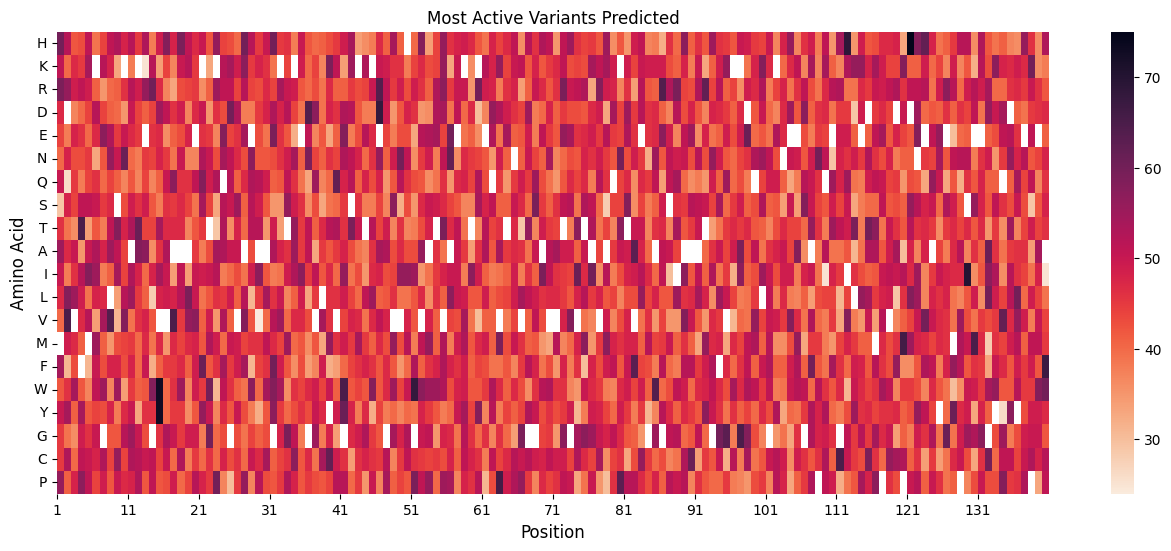

In [ ]:
most_act = muts.query('predictions > 0.1')
print(most_act.shape)

# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 141))

# fill the matix with the count of each amino acid in each position
for i in range(1, 141):
    pos_count = most_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

# plot the heatmap
plt.figure(figsize=(16, 6))
plt.title("Most Active Variants Predicted")
mtx.replace(0, np.nan, inplace=True)
sns.heatmap(mtx, cmap="rocket_r")
plt.xlabel('Position', size=12)
plt.ylabel('Amino Acid', size=12)
plt.yticks(rotation=0)
plt.xticks(np.arange(0, 140, 10), np.arange(1, 140, 10), rotation=0)
#plt.savefig('results/changes_heatmap_predictions_most_active.png', dpi=600)
plt.show()